# MLP Example

This Demo file will take you thorugh all the steps involved in predicting a tags value by using the values of other tags in the data source.

We'll use the sci-kit learn implementation of a Multi-layer perceptron (MLP) which is a simple neural network.

In this example the demo data source "IP Datasource 2" will be used as an example so make sure you have it authorised.

Set up the Intelligent Plant clients.

In [1]:
import intelligent_plant.app_store_client as app_store_client
import os
app_store = app_store_client.AppStoreClient(os.environ["ACCESS_TOKEN"])
data_core = app_store.get_data_core_client()

In [2]:
import intelligent_plant.utility as utility
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Look up the fully qualified names of authorised data sources.

Check that 'IP Datasource 2' appears in this list for you.

In [3]:
list(map(lambda x: x['Name']['QualifiedName'], data_core.get_data_sources(["*"])))

['IP Datasource', 'IP Datasource 2', 'Vibration']

We'll query all of the tags in IP Datasource 2 and make a list of just their names

In [4]:
dsn = "IP Datasource 2"

This code will page through every tag on the datasource and add it to a list. Note: on a real data source this would be a very expensive operation and is not advised. A much better approach would be to only query tags relevant to the problem you are trying to solve.

In [5]:
tags = []

page_size = 50
page_num = 1
while True:
    page = data_core.get_tags(dsn, page_num, page_size)
    
    #append the page just fetched into the list of all tags
    tags += page
    
    page_num += 1
    
    #if a page is shorter than the page size requested it is the last page
    if (len(page) < page_size):
        break

#map tages meta data to only be tag name and filter out the "TIME" tag
tag_names = list(filter(lambda x: x != "TIME", map(lambda x: x["Id"], tags)))

Fetch 10 days of data for the selected tags with a point every 1 hour. Data will be interpolated.

In [6]:
all_data = data_core.get_processed_data({dsn: tag_names}, "*-10d", "*", "1h", "interp")

Convert the returned data into a data frame to make it easier to work with

In [7]:
all_data_frame = utility.query_result_to_data_frame(all_data)

Remove the timestamp of data entries. For this simple example it will be ignored.

In [8]:
all_data_frame.drop('TimeStamp', axis=1, inplace=True)

In [9]:
all_data_frame

,T2 MPGC 2nd Stg Suct Scrubber_PI,T1 MPGC 1st Stg Suct Scrubber_PI,CALC_Scaled_HP Flare Header Wet_PI,LP FG Header_PI,MeOH Surge Vessel_PI,Demulsifier L.P. Inj Pump B_PI,FG Filter B_PI,Corrosion Inhibitor HP Inj Pump B_PI,Biocide (Oil) Inj Pump A_PI,T2 MPGC 1st Stg_Disc_PI,...,WI Pump B_Suct_PI,Polyelectrolyte_1 Inj Pump A_PI,SRP Feed Pump C_PI,LP Degasser_PI,PCM Drum_PI,Coagulant Inj Pump A_PI,Sand Hydrocyclone_PI,HP FG Scrubber_PI,Prod Riser Depress Heater_TS Out_PI,LP Flare KO Drum Pump C_Disc_PI
0,31.268032,15.067006,5.670209,5.940973,5.155453,25.934951,0.761326,4.614258,0.427984,32.530668,...,3.492396,1.352938,39.304427,1.374827,2.600486,3.331956,1.460858,39.572807,1.038695,0.441087
1,31.259241,15.071088,5.500146,5.899375,5.155453,25.869785,0.761326,4.614258,0.422324,32.511611,...,3.821132,1.350322,39.243873,1.384352,2.593056,3.337197,1.942283,39.528837,1.038695,0.437141
2,31.108460,15.026004,6.124345,5.853883,5.165637,25.691271,0.761326,4.614258,0.416664,32.389787,...,3.853683,1.347706,39.195807,1.383874,2.577600,3.342437,1.890709,39.500851,1.038695,0.414033
3,31.144559,15.005539,6.397647,5.816291,5.175507,25.733178,0.761326,4.614258,0.411004,32.392863,...,3.751958,1.345090,39.212820,1.389394,2.546443,3.347678,1.831817,39.496463,1.038695,0.419451
4,31.342722,15.028698,5.748946,5.883335,5.175507,25.790465,0.792523,4.614258,0.405345,32.644086,...,3.906062,1.342475,39.220402,1.380853,2.521479,3.352919,1.772281,39.538496,1.038695,0.431287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,31.270592,15.046552,5.910895,6.092145,5.155453,26.721506,0.761326,4.567662,0.433667,32.533284,...,3.618999,1.351770,40.050142,1.380432,2.587804,3.326693,0.954682,39.584947,1.038695,0.448279
237,31.267400,15.066941,5.671806,5.941938,5.155453,25.934120,0.761326,4.614258,0.428007,32.530458,...,3.489957,1.352949,39.304481,1.374773,2.600482,3.331934,1.456600,39.573207,1.038695,0.441009
238,31.259942,15.071119,5.499978,5.898763,5.155453,25.871155,0.761326,4.614258,0.422348,32.511978,...,3.820814,1.350333,39.244324,1.384327,2.593123,3.337175,1.942499,39.528806,1.038695,0.437251
239,31.109022,15.026347,6.119345,5.854858,5.165553,25.691410,0.761326,4.614258,0.416688,32.390436,...,3.853725,1.347717,39.195763,1.383904,2.577663,3.342416,1.890924,39.501113,1.038695,0.414117


We can plot the contents of a data frame easily

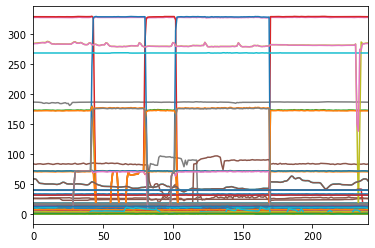

In [10]:
all_data_frame.plot(legend=False)

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

Set up a processing pipe. This encapsulates scaling and the MLP into the same pipe and allows us to train and test them all at once.

In [12]:
pipe = make_pipeline(StandardScaler(), MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100,), activation='logistic'))

Randomly split the data into training and testing.

We will try to predict the value of the last tag "WI Pump D_Suct_PI" by using the values of all the other tags.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(all_data_frame[tag_names[:-1]], all_data_frame[tag_names[-1]])

The MLP is going to try and learn the relationship between the graph above and below

Use the training data to train the model.

In [14]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('mlpregressor',
                 MLPRegressor(activation='logistic', alpha=1e-05,
                              batch_size='auto', beta_1=0.9, beta_2=0.999,
                              early_stopping=False, epsilon=1e-08,
                              hidden_layer_sizes=(100,),
                              learning_rate='constant',
                              learning_rate_init=0.001, max_iter=200,
                              momentum=0.9, n_iter_no_change=10,
                              nesterovs_momentum=True, power_t=0.5,
                              random_state=None, shuffle=True, solver='lbfgs',
                              tol=0.0001, validation_fraction=0.1,
                              verbose=False, warm_start=False))],
         verbose=False)

In [15]:
prediction = pipe.predict(X_test)

In [16]:
prediction_df = pd.DataFrame({ "actual": y_test, "prediction": prediction }).reset_index(drop=True)

We can use seaborn to generate a scatter plot of the models prediction against the known ground truth.

Ideally, a perfect result would create a straight line of x = y. Any deviation from that line is error in the model.

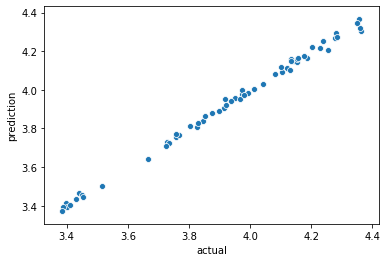

In [17]:
sns.scatterplot(prediction_df['actual'], prediction_df['prediction'])

The score function can be used to detemine the coefficient of determination (R^2) of our model. A score of 1 means that the prediction is perfect.

In [18]:
pipe.score(X_test, y_test)

0.9967009062275991

In [19]:
from sklearn.metrics import *

Other metrics can also be calculated. Such as the mean absoulte error. In this case 0 would be perfect.

In [20]:
mean_absolute_error(y_test, prediction)

0.012551885491064485